In [5]:
import os
from google.colab import drive
import zipfile
# 1. Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
! pip install torchmetrics

In [7]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torchmetrics.detection.mean_ap import MeanAveragePrecision

class GTSDBDataset(Dataset):
    def __init__(self, image_dir, annotations_file, image_names, transforms=None):
        self.image_dir = image_dir
        self.image_names = image_names
        self.transforms = transforms
        self.annotations = self._load_annotations(annotations_file)
        self.category_map = {
            'prohibitory': 1,
            'danger': 2,
            'mandatory': 3,
            'other': 4
        }

    def _load_annotations(self, annotations_file):
        annotations = {}
        with open(annotations_file, 'r') as f:
            for line in f:
                filename, left, top, right, bottom, class_id = line.strip().split(';')
                if filename not in annotations:
                    annotations[filename] = []
                annotations[filename].append({
                    'x1': int(left),
                    'y1': int(top),
                    'x2': int(right),
                    'y2': int(bottom),
                    'class_id': int(class_id)
                })
        return annotations

    def get_category(self, class_id):
        if class_id <= 5 or 7 <= class_id <= 10 or class_id in [15, 16]:
            return 'prohibitory'
        elif 18 <= class_id <= 31 or class_id == 11:
            return 'danger'
        elif 33 <= class_id <= 40:
            return 'mandatory'
        return 'other'

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []

        if img_name in self.annotations:
            for ann in self.annotations[img_name]:
                boxes.append([ann['x1'], ann['y1'], ann['x2'], ann['y2']])
                category = self.get_category(ann['class_id'])
                labels.append(self.category_map[category])

        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

class TrafficSignDetector:
    def __init__(self, num_classes):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._create_model(num_classes)
        self.model.to(self.device)

    def _create_model(self, num_classes):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model


    def train(self, train_loader, valid_loader, num_epochs=10):
        params = [p for p in self.model.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(params, lr=0.0001, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        best_map = 0
        history = {'train_loss': [], 'val_map': []}
        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print('-' * 50)
            for batch_idx, (images, targets) in enumerate(train_loader):
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                optimizer.zero_grad()
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                # Log individual loss components
                print(f"Batch {batch_idx + 1}/{len(train_loader)} - "
                      f"Loss: {losses.item():.4f} "
                      f"(Cls: {loss_dict['loss_classifier'].item():.4f}, "
                      f"Box: {loss_dict['loss_box_reg'].item():.4f}, "
                      f"RPN Obj: {loss_dict['loss_objectness'].item():.4f}, "
                      f"RPN Reg: {loss_dict['loss_rpn_box_reg'].item():.4f})")
                losses.backward()
                optimizer.step()
                epoch_loss += losses.item()
            # Validation
            val_map = self.evaluate(valid_loader)
            lr_scheduler.step()
            avg_train_loss = epoch_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            history['val_map'].append(val_map)

            print(f"\nEpoch {epoch+1}: Avg Train Loss={avg_train_loss:.4f}, Validation mAP={val_map:.4f}")

            if val_map > best_map:
                best_map = val_map
                # Save the model to Google Drive
                save_path = '/content/drive/MyDrive/traffic_sign_models/best_model.pth'
                torch.save(self.model.state_dict(), save_path)
                print(f"Model saved to {save_path} with mAP: {best_map}")

        # Plotting training loss and validation mAP
        self._plot_training_history(history)
        return history

    def load_model(self, path):
        """
        Loads the model's parameters from a file.

        Parameters:
        path (str): Path to the saved state dictionary file.
        """
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode
        print(f"Model loaded from {path}")

    def _plot_training_history(self, history):
        """
        Plots training loss and validation mAP over epochs.

        Parameters:
        history (dict): A dictionary with keys 'train_loss' and 'val_map', each containing a list of values.

        """
        epochs = range(1, len(history['train_loss']) + 1)

        plt.figure(figsize=(12, 5))

        # Plot Training Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], label='Training Loss', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # Plot Validation mAP
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['val_map'], label='Validation mAP', marker='o', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('mAP')
        plt.title('Validation mAP')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def evaluate(self, data_loader):
        self.model.eval()
        metric = MeanAveragePrecision(iou_type="bbox",iou_thresholds=[0.5], class_metrics=True)

        for images, targets in data_loader:
            images = [img.to(self.device) for img in images]
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
            outputs = self.model(images)

            # Adjust labels to start from 0 before passing to the metric
            for target in targets:
                target['labels'] = target['labels'] - 1
            for output in outputs:
                output['labels'] = output['labels'] - 1

            metric.update(outputs, targets)

        computed_metrics = metric.compute()
        return computed_metrics['map'].item()


    @torch.no_grad()
    def evaluate_by_size(self, data_loader, size_thresholds=(32, 45)):
        """
        Evaluates the model's performance (mAP) for different object sizes.

        Parameters:
        - data_loader: DataLoader for the dataset to evaluate.
        - size_thresholds: Tuple of thresholds to categorize object sizes (small, medium, large).

        Returns:
        - size_map: Dictionary containing mAP for 'small', 'medium', and 'large' objects.
        """
        self.model.eval()
        size_metrics = {
            'small': MeanAveragePrecision(iou_type="bbox",iou_thresholds=[0.5], class_metrics=True),
            'medium': MeanAveragePrecision(iou_type="bbox",iou_thresholds=[0.5], class_metrics=True),
            'large': MeanAveragePrecision(iou_type="bbox",iou_thresholds=[0.5], class_metrics=True)
        }

        for images, targets in data_loader:
            images = [img.to(self.device) for img in images]
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
            outputs = self.model(images)

            for target, output in zip(targets, outputs):
                # Adjust labels to start from 0
                target['labels'] = target['labels'] - 1
                output['labels'] = output['labels'] - 1

                # Get the size categories for each ground truth box
                size_categories = []
                for box in target['boxes']:
                    width = box[2] - box[0]
                    category = categorize_object_size(width, size_thresholds)
                    size_categories.append(category)

                # Separate targets and predictions by size category
                for size in ['small', 'medium', 'large']:
                    indices = [i for i, sc in enumerate(size_categories) if sc == size]
                    if not indices:
                        continue  # No objects of this size in this image

                    # Filter targets for this size category
                    size_target = {
                        'boxes': target['boxes'][indices],
                        'labels': target['labels'][indices],
                    }

                    # Initialize empty tensors for size_output
                    size_output = {
                        'boxes': torch.empty((0, 4), dtype=torch.float32, device=self.device),
                        'scores': torch.empty((0,), dtype=torch.float32, device=self.device),
                        'labels': torch.empty((0,), dtype=torch.int64, device=self.device),
                    }

                    if output['boxes'].numel() > 0 and size_target['boxes'].numel() > 0:
                        # Compute IoU between outputs and size_target boxes
                        ious = torchvision.ops.box_iou(output['boxes'], size_target['boxes'])
                        # For each detection, find the max IoU with ground truth boxes
                        max_ious, _ = ious.max(dim=1)
                        # Select detections with IoU > 0 (they overlap with size_target boxes)
                        selected_indices = (max_ious > 0).nonzero(as_tuple=True)[0]
                        if selected_indices.numel() > 0:
                            size_output = {
                                'boxes': output['boxes'][selected_indices],
                                'scores': output['scores'][selected_indices],
                                'labels': output['labels'][selected_indices],
                            }

                    # Update the metric for this size category
                    size_metrics[size].update([size_output], [size_target])

        # Compute mAP for each size category
        size_map = {}
        for size in ['small', 'medium', 'large']:
            computed_metrics = size_metrics[size].compute()
            size_map[size] = computed_metrics['map'].item()

        return size_map


    def analyze_performance(self, test_loader, iou_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9]):
        self.model.eval()
        results = []

        with torch.no_grad():
            for threshold in iou_thresholds:
                print(f"Evaluating for IoU threshold: {threshold}")
                # Remove num_classes argument
                metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[threshold], class_metrics=True)

                for images, targets in test_loader:
                    images = [img.to(self.device) for img in images]
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                    outputs = self.model(images)

                    # Adjust labels to start from 0 before passing to the metric
                    for target in targets:
                        target['labels'] = target['labels'] - 1
                    for output in outputs:
                        output['labels'] = output['labels'] - 1

                    metric.update(outputs, targets)
                computed_metrics = metric.compute()

                # Convert map_per_class to a list
                map_per_class = computed_metrics['map_per_class'].tolist()
                mAP = computed_metrics['map'].item()

                print(f"For IoU {threshold}, mAP: {mAP}, mAP per class: {map_per_class}")

                results.append({
                    'iou_threshold': threshold,
                    'map': mAP,
                    'map_per_class': map_per_class
                })

        return results



def get_transforms(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def visualize_results(model, image_path, device, conf_threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    transform = get_transforms(train=False)
    image_tensor = transform(image)

    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])

    image_np = np.array(image)
    for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
        print(f"Boxes: {box}, Scores: {score}, Labels: {label}")
        if score > conf_threshold:
            box = box.cpu().numpy()
            cv2.rectangle(image_np,
                         (int(box[0]), int(box[1])),
                         (int(box[2]), int(box[3])),
                         (255, 0, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

def plot_performance_curves(results, iou_thresholds):
    plt.figure(figsize=(10, 6))
    categories = ['prohibitory', 'danger', 'mandatory', 'other']

    for i, category in enumerate(categories):
        ap_values = []
        for result in results:
            map_per_class = result.get('map_per_class', [])
            if len(map_per_class) > i:
                ap_values.append(map_per_class[i])
            else:
                ap_values.append(0.0)

        print(f"Category: {category}, IoU AP values: {ap_values}")
        plt.plot(iou_thresholds, ap_values, marker='o', label=category)

    plt.xlabel('IoU Threshold')
    plt.ylabel('Average Precision')
    plt.title('Performance vs IoU Threshold by Category')
    plt.legend()
    plt.grid(True)
    plt.show()



def categorize_object_size(width, thresholds=(32, 45)):
    if width < thresholds[0]:
        return 'small'
    elif thresholds[0] <= width <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

def plot_size_accuracy(size_map):
    sizes = list(size_map.keys())
    accuracies = [size_map[size] if size_map[size] is not None else 0 for size in sizes]
    plt.bar(sizes, accuracies)
    plt.xlabel('Object Size')
    plt.ylabel('mAP')
    plt.title('Performance by Object Size')
    plt.grid(True)
    plt.show()


In [8]:
# Paths
image_dir = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/"
annotations_file = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/gt.txt"
train_file = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/train_files.npy"
test_file = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/test_files.npy"
model_path = '/content/drive/MyDrive/traffic_sign_models/best_model.pth'

# Load train and test filenames
train_names = np.load(train_file, allow_pickle=True)
test_names = np.load(test_file, allow_pickle=True)

# Create datasets
train_dataset = GTSDBDataset(image_dir, annotations_file, train_names, get_transforms(train=True))
test_dataset = GTSDBDataset(image_dir, annotations_file, test_names, get_transforms(train=False))

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)), num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)), num_workers=2
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 149MB/s]


No saved model found. Starting training...

Epoch 1/10
--------------------------------------------------
Batch 1/74 - Loss: 2.3291 (Cls: 1.6777, Box: 0.0217, RPN Obj: 0.6111, RPN Reg: 0.0186)
Batch 2/74 - Loss: 0.9260 (Cls: 0.6748, Box: 0.0181, RPN Obj: 0.2270, RPN Reg: 0.0060)
Batch 3/74 - Loss: 1.1836 (Cls: 0.0929, Box: 0.0188, RPN Obj: 1.0425, RPN Reg: 0.0293)
Batch 4/74 - Loss: 0.7038 (Cls: 0.0881, Box: 0.0282, RPN Obj: 0.5747, RPN Reg: 0.0128)
Batch 5/74 - Loss: 0.2398 (Cls: 0.0525, Box: 0.0159, RPN Obj: 0.1622, RPN Reg: 0.0093)
Batch 6/74 - Loss: 0.3008 (Cls: 0.1190, Box: 0.0426, RPN Obj: 0.1300, RPN Reg: 0.0093)
Batch 7/74 - Loss: 0.7344 (Cls: 0.2489, Box: 0.0797, RPN Obj: 0.3827, RPN Reg: 0.0231)
Batch 8/74 - Loss: 0.1876 (Cls: 0.0426, Box: 0.0113, RPN Obj: 0.1196, RPN Reg: 0.0141)
Batch 9/74 - Loss: 0.2859 (Cls: 0.0906, Box: 0.0368, RPN Obj: 0.1417, RPN Reg: 0.0168)
Batch 10/74 - Loss: 0.5152 (Cls: 0.0552, Box: 0.0154, RPN Obj: 0.4080, RPN Reg: 0.0366)
Batch 11/74 - Loss: 0.3

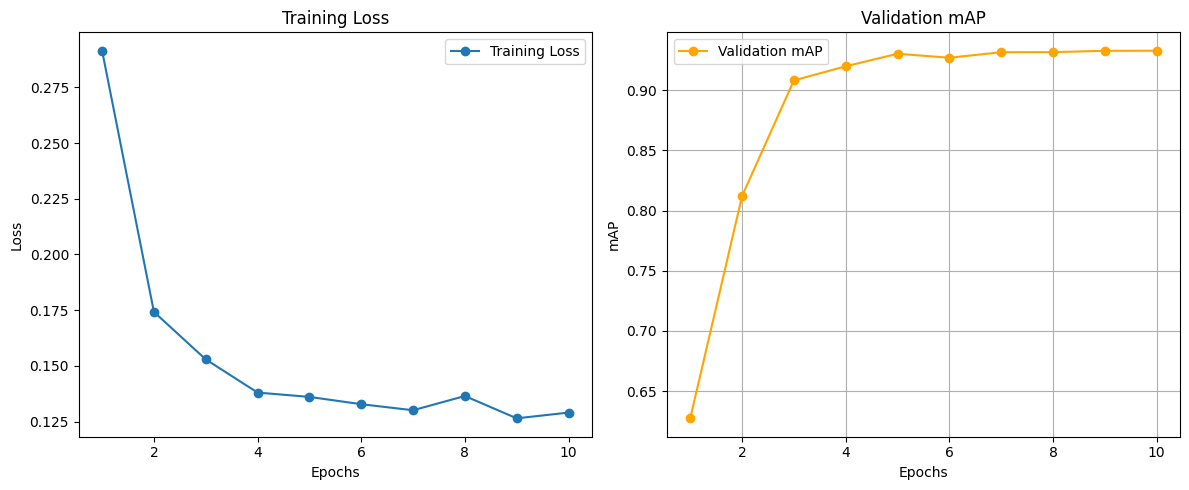

In [9]:
# Initialize the traffic sign detection model
detector = TrafficSignDetector(num_classes=5)  # 4 classes + background

# Load the saved model or train
if os.path.exists(model_path):
    print(f"Loading the saved model from {model_path}...")
    detector.load_model(model_path)
else:
    print("No saved model found. Starting training...")
    os.makedirs('/content/drive/MyDrive/traffic_sign_models/', exist_ok=True)
    detector.train(train_loader, test_loader)


Analyzing performance vs IoU thresholds...
Evaluating for IoU threshold: 0.5
For IoU 0.5, mAP: 0.9329258799552917, mAP per class: [0.9723795056343079, 0.9512543678283691, 0.8841301202774048, 0.9239394664764404]
Evaluating for IoU threshold: 0.6
For IoU 0.6, mAP: 0.9329258799552917, mAP per class: [0.9723795056343079, 0.9512543678283691, 0.8841301202774048, 0.9239394664764404]
Evaluating for IoU threshold: 0.7
For IoU 0.7, mAP: 0.9278489351272583, mAP per class: [0.9723795056343079, 0.9309465289115906, 0.8841301202774048, 0.9239394664764404]
Evaluating for IoU threshold: 0.8
For IoU 0.8, mAP: 0.839751660823822, mAP per class: [0.8928550481796265, 0.7788634300231934, 0.8266146779060364, 0.8606733679771423]
Evaluating for IoU threshold: 0.9
For IoU 0.9, mAP: 0.24033169448375702, mAP per class: [0.30528128147125244, 0.2666666805744171, 0.24742768704891205, 0.14195114374160767]
Category: prohibitory, IoU AP values: [0.9723795056343079, 0.9723795056343079, 0.9723795056343079, 0.892855048179

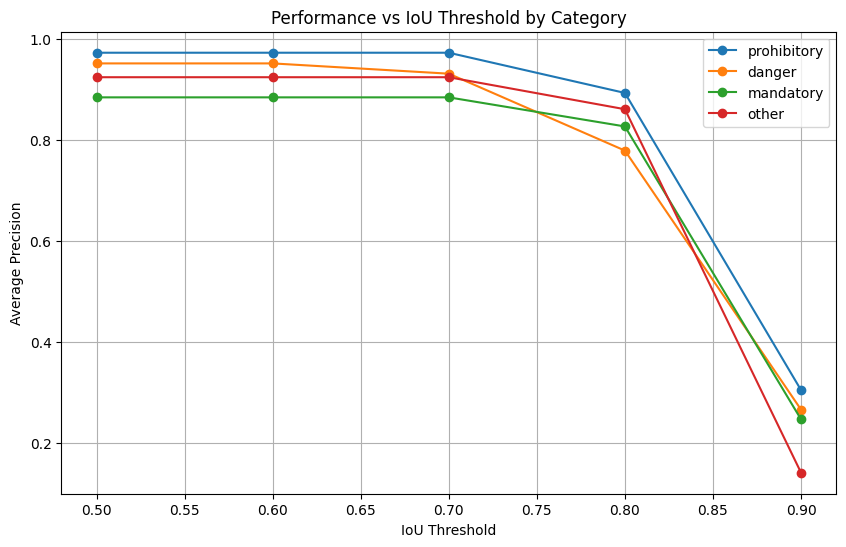

In [10]:
# Analyze performance over IoU thresholds
print("\nAnalyzing performance vs IoU thresholds...")
iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
results = detector.analyze_performance(test_loader, iou_thresholds)
plot_performance_curves(results, iou_thresholds)


Evaluating performance by object size...
Performance by object size: {'small': 0.846594512462616, 'medium': 0.9025011658668518, 'large': 0.9581117630004883}


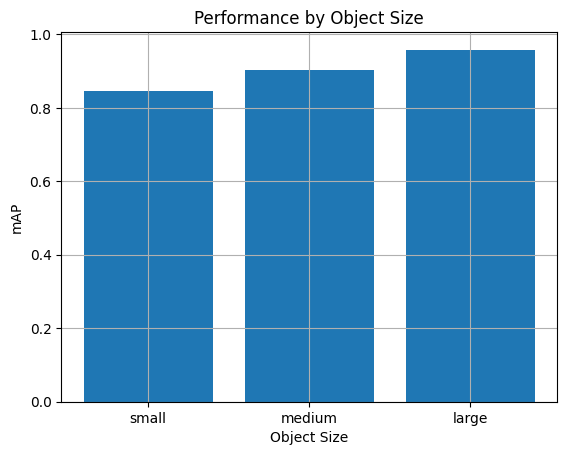

In [11]:
# Evaluate performance by object size
print("\nEvaluating performance by object size...")
size_thresholds = (32, 45)  # Adjust thresholds as needed
size_map = detector.evaluate_by_size(test_loader, size_thresholds)
print(f"Performance by object size: {size_map}")
plot_size_accuracy(size_map)

In [12]:
def visualize_results_with_ground_truth(model, image_path, annotations, device, conf_threshold=0.5):
    """
    Visualize both model predictions and ground truth annotations

    Args:
        model: The trained model
        image_path: Path to the image file
        annotations: Dictionary containing ground truth annotations
        device: torch device (cuda/cpu)
        conf_threshold: Confidence threshold for predictions
    """
    # Define category mapping
    category_map = {
        1: 'prohibitory',
        2: 'danger',
        3: 'mandatory',
        4: 'other'
    }

    # Define colors for different purposes (BGR format for OpenCV)
    colors = {
        'prediction': (255, 0, 0),    # Red for predictions
        'ground_truth': (0, 255, 0),  # Green for ground truth
        'match': (0, 0, 255)          # Blue for matching predictions
    }

    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    transform = get_transforms(train=False)
    image_tensor = transform(image)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]

    # Convert image to numpy for drawing
    image_np = np.array(image)

    # Get ground truth annotations for this image
    image_name = os.path.basename(image_path)
    gt_boxes = annotations.get(image_name, [])

    # Draw ground truth boxes first
    for gt in gt_boxes:
        x1, y1, x2, y2 = gt['x1'], gt['y1'], gt['x2'], gt['y2']
        category = get_category(gt['class_id'])  # You'll need to implement this based on your mapping

        # Draw ground truth box in green
        cv2.rectangle(image_np, (x1, y1), (x2, y2), colors['ground_truth'], 2)

        # Add ground truth label
        gt_label = f"GT: {category}"
        cv2.putText(image_np, gt_label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, colors['ground_truth'], 2)

    # Draw prediction boxes
    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score > conf_threshold:
            box = box.cpu().numpy()
            x1, y1, x2, y2 = map(int, box)
            predicted_category = category_map.get(label.item(), 'unknown')

            # Check if this prediction matches any ground truth box
            is_match = False
            for gt in gt_boxes:
                iou = calculate_iou(box, [gt['x1'], gt['y1'], gt['x2'], gt['y2']])
                if iou > 0.5:  # IOU threshold
                    is_match = True
                    break

            # Choose color based on whether it's a match
            color = colors['match'] if is_match else colors['prediction']

            # Draw prediction box
            cv2.rectangle(image_np, (x1, y1), (x2, y2), color, 2)

            # Add prediction label with confidence score
            pred_label = f"Pred: {predicted_category} ({score:.2f})"
            cv2.putText(image_np, pred_label, (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color, 2)

    # Add legend
    legend_y = 30
    for key, color in colors.items():
        cv2.putText(image_np, key, (10, legend_y), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color, 2)
        legend_y += 20

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Traffic Sign Detection Results: {image_name}")
    plt.show()

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union between two bounding boxes
    """
    # Convert boxes to coordinates
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Calculate intersection coordinates
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)

    # Calculate areas
    intersection_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def get_category(class_id):
    if class_id <= 5 or 7 <= class_id <= 10 or class_id in [15, 16]:
        return 'prohibitory'
    elif 18 <= class_id <= 31 or class_id == 11:
        return 'danger'
    elif 33 <= class_id <= 40:
        return 'mandatory'
    return 'other'


Visualizing sample predictions...


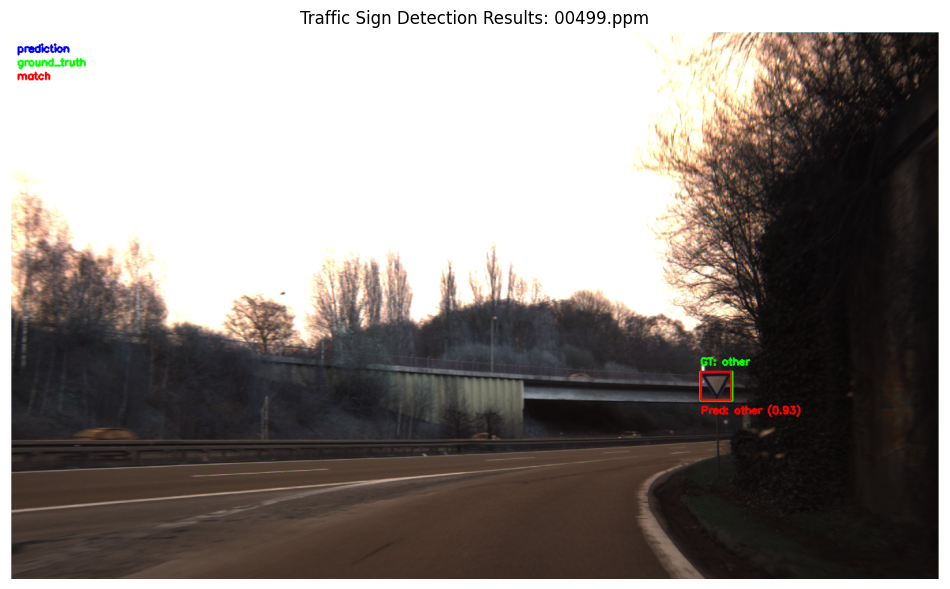


All tasks completed!


In [13]:
# Visualize a sample prediction
print("\nVisualizing sample predictions...")
image_path = os.path.join(image_dir, test_names[20])
visualize_results_with_ground_truth(
    model=detector.model,
    image_path=image_path,
    annotations=test_dataset.annotations,
    device=detector.device
)

print("\nAll tasks completed!")